In [ ]:
# GAi App Data Epochs=10,Data Increased ,Cropped Images Left,Right Corners cropped and Resized Images Epochs=10, ROTATED IMAGES 320x240 ,30 Batchsize 5 Classes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
from google.oauth2 import service_account
from googleapiclient.discovery import build

# Set up the service account credentials
credentials = service_account.Credentials.from_service_account_file('/content/drive/MyDrive/Credentials.json')
drive_service = build('drive', 'v3', credentials=credentials)

# ID of the archive.zip file on Google Drive
file_id = '1g3J3n2QsbLwepYzGPVZfyOyMHtmHfQfA'

# Download the file
request = drive_service.files().get_media(fileId=file_id)
downloaded_file = request.execute()

with open('Gai_Dataset.zip', 'wb') as f:
    f.write(downloaded_file)

# Unzip the file
with zipfile.ZipFile('Gai_Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Clean up: Delete the downloaded zip file
os.remove('Gai_Dataset.zip')

print('Extraction completed successfully.')


Extraction completed successfully.


In [ ]:
# Common imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, List

# Data Imports
import pandas as pd
from tqdm import tqdm
from glob import glob
from tensorflow import data as tfd
from tensorflow import image as tfi

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls

# Model Architecture
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Model Hypertunning
# !pip install -q keras_tuner
# cls()
# import keras_tuner as kt

In [ ]:
# Constants
IMAGE_SIZE1 = 240 # Height of the input image
IMAGE_SIZE2 = 320 # Width of the input image
BATCH_SIZE = 30 # number of samples per gradient update
EPOCHS = 10 # number of epochs to train the model

# Hyperparameters
LEARNING_RATE = 1e-3 # learning rate for the optimizer

# Specify the directory paths for the data
root_dir = "Gai_Dataset/"
train_dir = f"{root_dir}train/" # path to the directory containing training data
# train_dir = f"train/" # path to the directory containing training data
valid_dir = f"{root_dir}valid/" # path to the directory containing validation data
# valid_dir = f"valid/" # path to the directory containing validation data
test_dir = f"{root_dir}test/" # path to the directory containing test data
# test_dir = f"test/" # path to the directory containing test data

# Model training
LOSS = 'sparse_categorical_crossentropy'
METRICS = ['accuracy']

# Random Seed
#random_seed = 42 # set random seed for reproducibility
#tf.random.set_seed(random_seed) # set random seed for TensorFlow
#np.random.seed(random_seed) # set random seed for NumPy



In [ ]:
# Collect the class names
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)

# Show
print(f"Total number of classes: {n_classes}")
print(f"Classes: {class_names}")

Total number of classes: 5
Classes: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']


In [ ]:
def load_image(image_path: str) -> tf.Tensor:

    '''
    The task of the function is to load the image present in the specified given image path. Loading the image the function also performed some
    preprocessing steps such as resizing and normalization.

    Argument:
        image_path(str) : This is a string which represents the location of the image file to be loaded.

    Returns:
        image(tf.Tensor) : This is the image which is loaded from the given image part in the form of a tensor.
    '''

    # Check if image path exists
    assert os.path.exists(image_path), f'Invalid image path: {image_path}'

    # Read the image file
    image = tf.io.read_file(image_path)

    # Load the image
    try:
        image = tfi.decode_jpeg(image, channels=3)
    except:
        image = tfi.decode_png(image, channels=3)

    # Change the image data type
    image = tfi.convert_image_dtype(image, tf.float32)

    # Resize the Image
    image = tfi.resize(image, (IMAGE_SIZE1, IMAGE_SIZE2))

    # Convert image data type to tf.float32
    image = tf.cast(image, tf.float32)

    return image


In [ ]:
def load_dataset(root_path: str, class_names: list, trim: int=None) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Load and preprocess images from the given root path and return them as numpy arrays.

    Args:
        root_path (str): Path to the root directory where all the subdirectories (class names) are present.
        class_names (list): List of the names of all the subdirectories (class names).
        trim (int): An integer value used to reduce the size of the data set if required.

    Returns:
        Two numpy arrays, one containing the images and the other containing their respective labels.
    '''

    if trim:
        # Trim the size of the data
        n_samples = len(class_names) * trim
    else:
        # Collect total number of data samples
        n_samples = sum([len(os.listdir(os.path.join(root_path, name))) for name in class_names])

    # Create arrays to store images and labels
    images = np.empty(shape=(n_samples, IMAGE_SIZE1, IMAGE_SIZE2, 3), dtype=np.float32)
    labels = np.empty(shape=(n_samples, 1), dtype=np.int32)

    # Loop over all the image file paths, load and store the images with respective labels
    n_image = 0
    for class_name in tqdm(class_names, desc="Loading"):
        class_path = os.path.join(root_path, class_name)
        image_paths = list(glob(os.path.join(class_path, "*")))[:trim]
        for file_path in image_paths:
            # Load the image
            image = load_image(file_path)

            # Assign label
            label = class_names.index(class_name)

            # Store the image and the respective label
            images[n_image] = image
            labels[n_image] = label

            # Increment the number of images processed
            n_image += 1

    # Shuffle the data
    indices = np.random.permutation(n_samples)
    images = images[indices]
    labels = labels[indices]


    return images, labels

In [ ]:
# Load the training dataset
X_train, y_train = load_dataset(root_path = train_dir, class_names = class_names, trim=700)  # 1000 images per class

# # Load the validation dataset
X_valid, y_valid = load_dataset(root_path = valid_dir, class_names = class_names)

# Load the testing dataset
X_test, y_test = load_dataset(root_path = test_dir, class_names = class_names)

Loading: 100%|██████████| 5/5 [00:00<00:00, 13.41it/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_images(images: np.ndarray, labels: np.ndarray, n_rows: int=1, n_cols: int=5, figsize: tuple=(25, 8), model=None) -> None:
    """
    Plots a grid of consecutive images and their corresponding labels, with an optional prediction from a given model.

    Args:
        images (np.ndarray): Array of images to plot.
        labels (np.ndarray): Array of labels corresponding to the images.
        n_rows (int): Number of rows in the plot grid. Default is 1.
        n_cols (int): Number of columns in the plot grid. Default is 5.
        figsize (tuple): A tuple specifying the size of the Fruits Classification_Rawdata320x240figure. Default is (25, 8).
        model: A Keras model object used to make predictions on the images. Default is None.

    Returns:
        None
    """

    # Calculate the total number of images available
    num_images = len(images)

    # Calculate the total number of plots
    total_plots = n_rows * n_cols

    # Calculate the number of rows needed to display all images
    num_required_rows = int(np.ceil(num_images / n_cols))

    # Ensure n_rows is not greater than the number of required rows
    n_rows = min(n_rows, num_required_rows)

    # Loop over each row of the plot
    for row in range(n_rows):
        # Create a new figure for each row
        plt.figure(figsize=figsize)

        # Calculate the starting index for the current row
        start_index = row * n_cols

        # Calculate the ending index for the current row
        end_index = min((row + 1) * n_cols, num_images)

        # Loop over each column of the plot
        for col, index in enumerate(range(start_index, end_index)):
            # Get the image and label at the current index
            image = images[index]
            label = class_names[int(labels[index])]

            # If a model is provided, make a prediction on the image
            if model:
                prediction = model.predict(np.expand_dims(tf.squeeze(image), axis=0), verbose=0)[0]
                conf = np.max(prediction, axis=-1)
                label += "\nPrediction: {} - {:.4}".format(class_names[np.argmax(prediction)], conf)

            # Plot the image and label
            plt.subplot(1, n_cols, col+1)
            plt.imshow(image)
            plt.title(label.title())
            plt.axis("off")

        # Show the row of images
        plt.show()




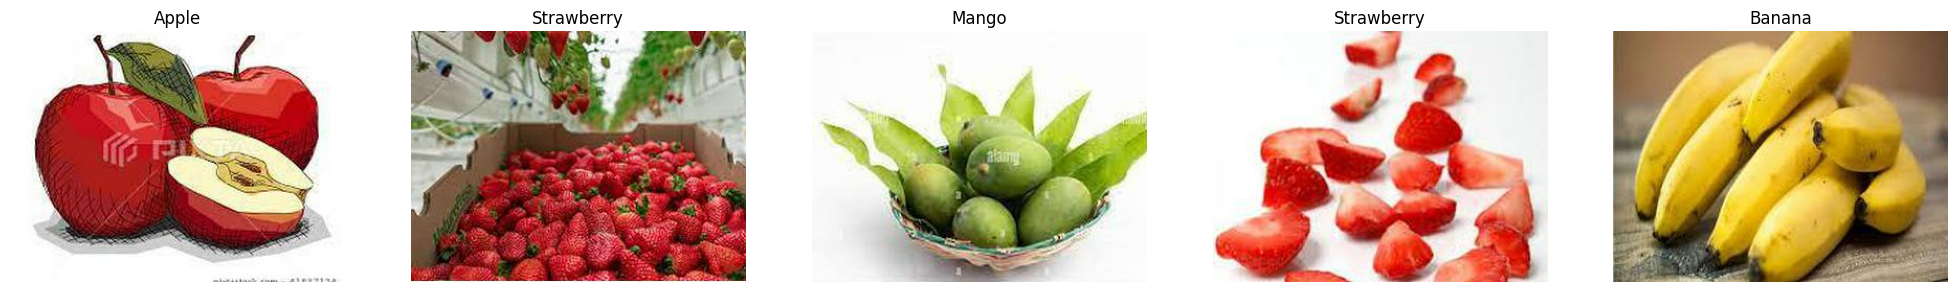

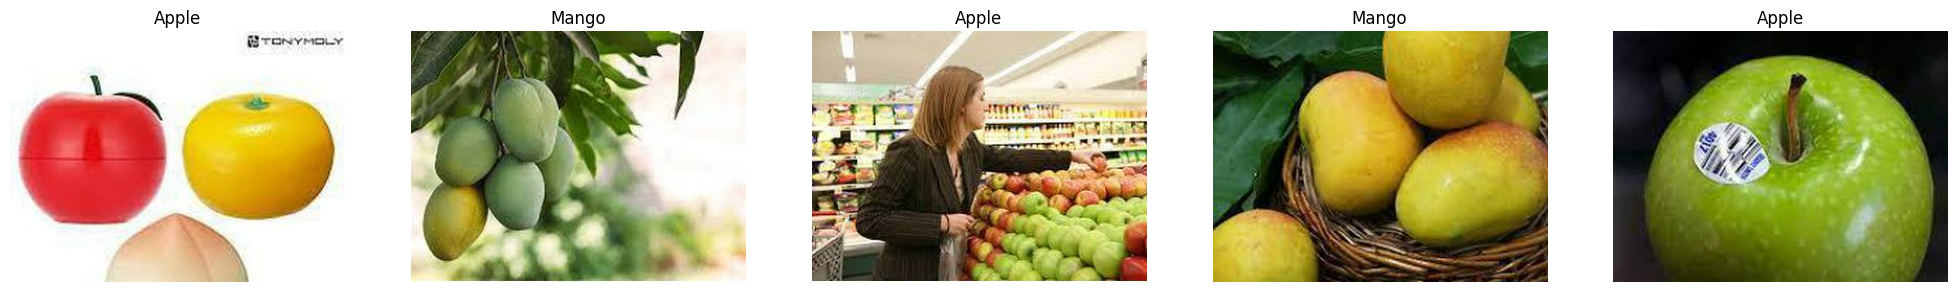

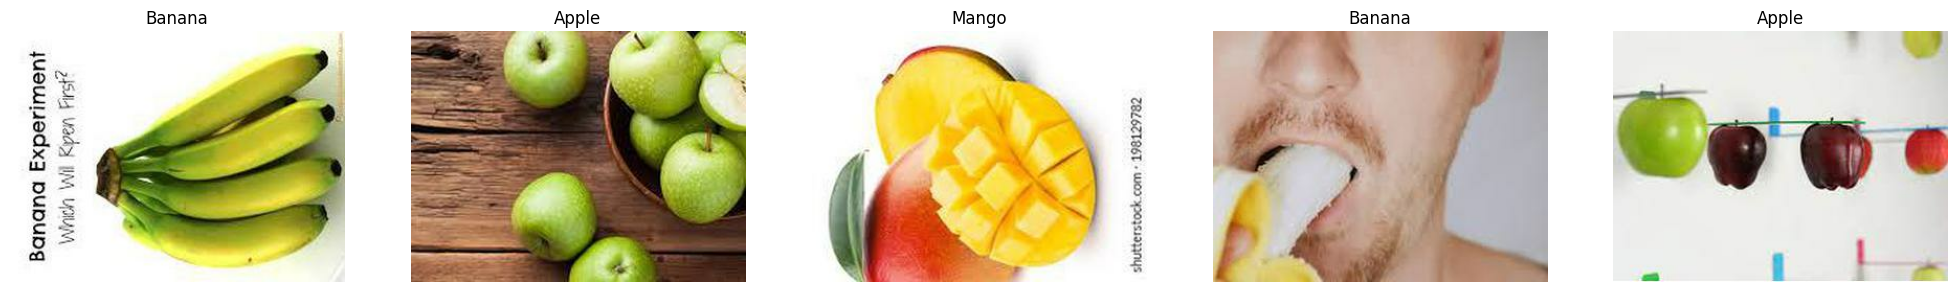

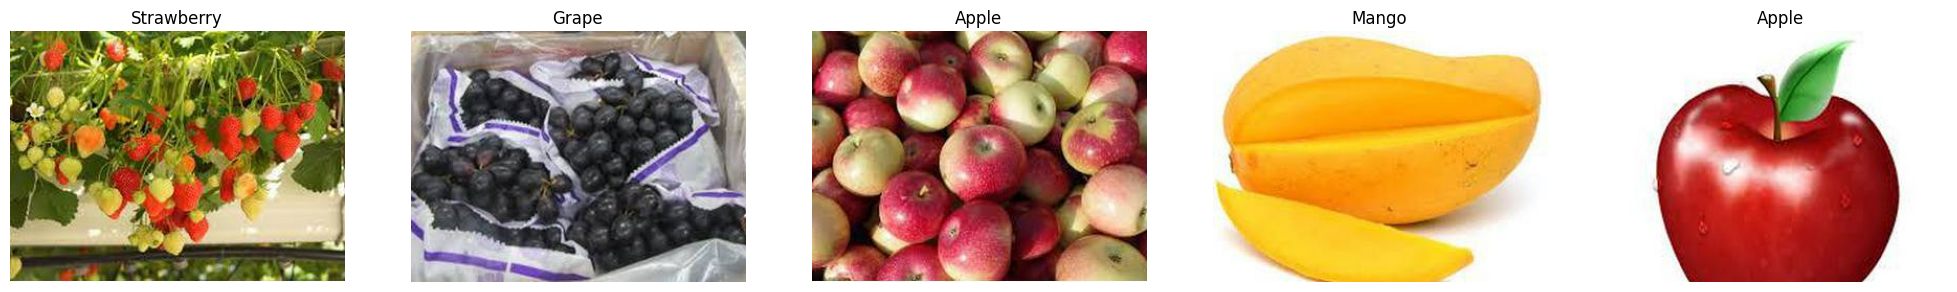

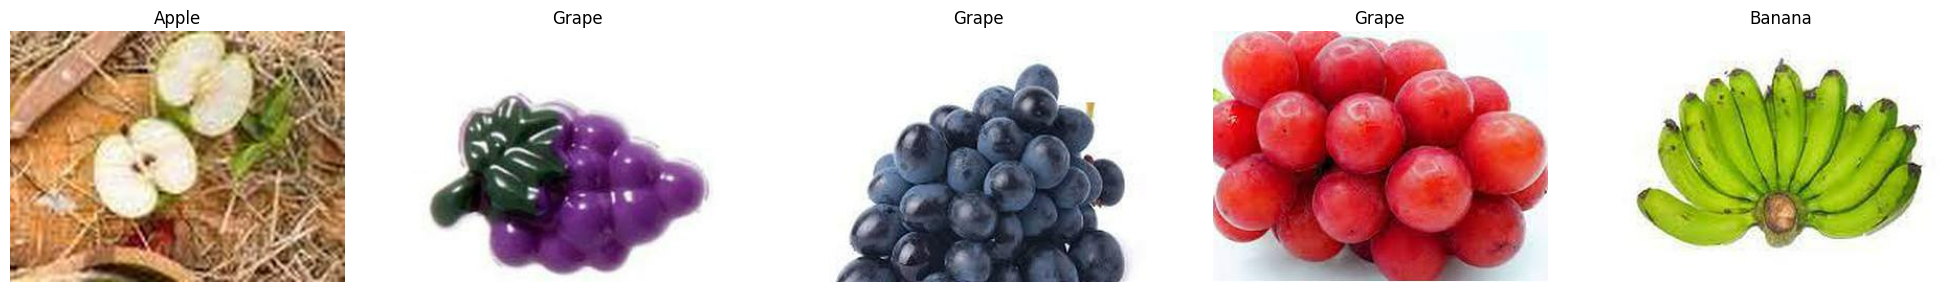

In [ ]:
# Visualize Training Dataset
show_images(images=X_train, labels=y_train, n_rows=5)

In [ ]:
# Mobilenet Backbone
print("Loading MobileNet Backbone: ")
mobilenet = MobileNetV2(input_shape=(IMAGE_SIZE1, IMAGE_SIZE2, 3), weights='imagenet', include_top=False)

# Freeze the model weights
mobilenet.trainable = False

# The Mobilenet Model baseline
mobilenet = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

# Compile the Baseline
mobilenet.compile(
    loss=LOSS,
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS
)

# Train the Xception Baseline Model
print("\nTraining Baseline Model: ")
mobilenet.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint("GaiApp_MobileNetV2Baseline.h5", save_best_only=True)
    ],
    batch_size=BATCH_SIZE
)



Loading MobileNet Backbone: 
9406464/9406464 [==============================] - 0s 0us/step

Training Baseline Model: 
Epoch 1/10
117/117 [==============================] - 297s 3s/step - loss: 1.0358 - accuracy: 0.6089 - val_loss: 0.6195 - val_accuracy: 0.7667
Epoch 2/10
117/117 [==============================] - 330s 3s/step - loss: 0.6359 - accuracy: 0.7723 - val_loss: 0.5140 - val_accuracy: 0.8100
Epoch 3/10
117/117 [==============================] - 285s 2s/step - loss: 0.5439 - accuracy: 0.8009 - val_loss: 0.4782 - val_accuracy: 0.8283
Epoch 4/10
117/117 [==============================] - 285s 2s/step - loss: 0.5037 - accuracy: 0.8214 - val_loss: 0.4479 - val_accuracy: 0.8400
Epoch 5/10
117/117 [==============================] - 283s 2s/step - loss: 0.4638 - accuracy: 0.8343 - val_loss: 0.4244 - val_accuracy: 0.8433
Epoch 6/10
117/117 [==============================] - 322s 3s/step - loss: 0.4234 - accuracy: 0.8471 - val_loss: 0.4232 - val_accuracy: 0.8517
Epoch 7/10
117/117 [===

In [ ]:
# Training Evaluation
mobilenet_train_loss, mobilenet_train_acc = mobilenet.evaluate(X_train, y_train)
print(f"\nMobileNet Baseline Training Loss     : {mobilenet_train_loss}.")
print(f"MobileNet Baseline Training Accuracy : {mobilenet_train_acc}.")


110/110 [==============================] - 239s 2s/step - loss: 0.2422 - accuracy: 0.9251

MobileNet Baseline Training Loss     : 0.24216555058956146.
MobileNet Baseline Training Accuracy : 0.9251428842544556.


In [ ]:
# Validation Evaluation
mobilenet_valid_loss, mobilenet_valid_acc = mobilenet.evaluate(X_valid, y_valid)
print(f"\nMobileNet Baseline Validation Loss     : {mobilenet_valid_loss}.")
print(f"MobileNet Baseline Validation Accuracy : {mobilenet_valid_acc}.")


19/19 [==============================] - 43s 2s/step - loss: 0.4102 - accuracy: 0.8483

MobileNet Baseline Validation Loss     : 0.4101945161819458.
MobileNet Baseline Validation Accuracy : 0.8483333587646484.


In [ ]:
# Testing Evaluation
mobilenet_test_loss, mobilenet_test_acc = mobilenet.evaluate(X_test, y_test)
print(f"\nMobileNet Baseline Testing Loss     : {mobilenet_test_loss}.")
print(f"MobileNet Baseline Testing Accuracy : {mobilenet_test_acc}.")

4/4 [==============================] - 8s 2s/step - loss: 0.5705 - accuracy: 0.7900

MobileNet Baseline Testing Loss     : 0.57049161195755.
MobileNet Baseline Testing Accuracy : 0.7900000214576721.


In [ ]:
# Make predictions
baseline_pred = np.argmax(mobilenet.predict(X_test, verbose=0), axis=-1)


# Evaluate prediction : Precision
baseline_pre = precision_score(y_test, baseline_pred, average='macro')


# Evaluate prediction : Recall
baseline_recall = recall_score(y_test, baseline_pred, average='macro')


# Evaluate prediction : F1 Score
baseline_f1 = f1_score(y_test, baseline_pred, average='macro')


print("{:20} ".format("Baseline Performance"))
print("{:10} : {:.5}".format("Precision", baseline_pre))
print("{:10} : {:.5}".format("Recall", baseline_recall))
print("{:10} : {:.5}".format("F1 Score", baseline_f1))

Baseline Performance 
Precision  : 0.84843
Recall     : 0.79
F1 Score   : 0.78788


In [ ]:
show_images(images=X_test, labels=y_test, model=mobilenet, n_rows=20)

In [ ]:
def build_model(hp):

    # Define all hyperparms
    mobilenet = MobileNetV2(input_shape=(IMAGE_SIZE1, IMAGE_SIZE2, 3), weights='imagenet', include_top=False)
    mobilenet.trainable = False
    n_layers = 2
    dropout_rate = 0.4
    n_units = 512
    learning_rate = 0.0001

    # Mode architecture
    model = Sequential([
        mobilenet,
        GlobalAveragePooling2D(),
    ])

    # Add hidden/top layers
    for _ in range(n_layers):
        model.add(Dense(n_units, activation='relu', kernel_initializer='he_normal'))

    # Add Dropout Layer
    model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(
        loss=LOSS,
        optimizer = Adam(learning_rate),
        metrics = METRICS
    )

    # Return model
    return model

In [ ]:
# Best Hyper params
# best_hps = random_searcher.get_best_hyperparameters()[0]
# print(f"Best Hyper Params founded: {best_hps.values}\n")

# Build the best model
mobile_net_model = build_model(mobilenet)
mobile_net_model.summary()

# Compile the model
print("\nTraining Best Model Architecture : ")
mobile_net_model_history = mobile_net_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint('GaiApp_Epoch10BestMobileNet.h5', save_best_only=True)
    ]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 10, 1280)      2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 512)               655872    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                

In [ ]:
# Training Evaluation
print("HyperParameter Tuning...")
mobilenet_train_loss_hyper, mobilenet_train_acc_hyper = mobile_net_model.evaluate(X_train, y_train)
print(f"\nMobileNet Baseline Training Loss     : {mobilenet_train_loss_hyper}.")
print(f"MobileNet Baseline Training Accuracy : {mobilenet_train_acc_hyper}.")


HyperParameter Tuning...
110/110 [==============================] - 228s 2s/step - loss: 0.0572 - accuracy: 0.9940

MobileNet Baseline Training Loss     : 0.05723617225885391.
MobileNet Baseline Training Accuracy : 0.9940000176429749.


In [ ]:
# Validation Evaluation
mobilenet_valid_loss_hyper, mobilenet_valid_acc_hyper = mobile_net_model.evaluate(X_valid, y_valid)
print(f"\nMobileNet Baseline Validation Loss     : {mobilenet_valid_loss_hyper}.")
print(f"MobileNet Baseline Validation Accuracy : {mobilenet_valid_acc_hyper}.")


19/19 [==============================] - 39s 2s/step - loss: 0.3773 - accuracy: 0.8783

MobileNet Baseline Validation Loss     : 0.37734508514404297.
MobileNet Baseline Validation Accuracy : 0.878333330154419.


In [ ]:
# Testing Evaluation
mobilenet_test_loss_hyper, mobilenet_test_acc_hyper = mobile_net_model.evaluate(X_test, y_test)
print(f"\nMobileNet Baseline Testing Loss     : {mobilenet_test_loss_hyper}.")
print(f"MobileNet Baseline Testing Accuracy : {mobilenet_test_acc_hyper}.")

4/4 [==============================] - 7s 2s/step - loss: 0.5778 - accuracy: 0.7900

MobileNet Baseline Testing Loss     : 0.5777890086174011.
MobileNet Baseline Testing Accuracy : 0.7900000214576721.


In [ ]:
# Make predictions
baseline_pred = np.argmax(mobilenet.predict(X_test, verbose=0), axis=-1)
best_pred = np.argmax(mobile_net_model.predict(X_test, verbose=0), axis=-1)

# Evaluate prediction : Precision
baseline_pre = precision_score(y_test, baseline_pred, average='macro')
best_pre = precision_score(y_test, best_pred, average='macro')

# Evaluate prediction : Recall
baseline_recall = recall_score(y_test, baseline_pred, average='macro')
best_recall = recall_score(y_test, best_pred, average='macro')

# Evaluate prediction : F1 Score
baseline_f1 = f1_score(y_test, baseline_pred, average='macro')
best_f1 = f1_score(y_test, best_pred, average='macro')

print("{:20} | {:20}".format("Baseline Performance", "Best Performance\n"))
print("{:10} : {:.5}  | {:.5}".format("Precision", baseline_pre, best_pre))
print("{:10} : {:.5}    | {:.5}".format("Recall", baseline_recall, best_recall))
print("{:10} : {:.5} | {:.5}".format("F1 Score", baseline_f1, best_f1))

Baseline Performance | Best Performance
   
Precision  : 0.84843  | 0.81266
Recall     : 0.79    | 0.79
F1 Score   : 0.78788 | 0.7896


In [ ]:
print(classification_report(y_test, baseline_pred))

              precision    recall  f1-score   support

           0       0.56      0.90      0.69        20
           1       0.73      0.80      0.76        20
           2       0.95      1.00      0.98        20
           3       1.00      0.45      0.62        20
           4       1.00      0.80      0.89        20

    accuracy                           0.79       100
   macro avg       0.85      0.79      0.79       100
weighted avg       0.85      0.79      0.79       100



In [ ]:
print(classification_report(y_test, best_pred))

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        20
           1       0.86      0.90      0.88        20
           2       0.83      0.95      0.88        20
           3       0.76      0.65      0.70        20
           4       1.00      0.65      0.79        20

    accuracy                           0.79       100
   macro avg       0.81      0.79      0.79       100
weighted avg       0.81      0.79      0.79       100



In [ ]:
show_images(images=X_test, labels=y_test, model=mobile_net_model, n_rows=20)

In [ ]:
# Training Evaluation
print("HyperParameter Tuning...")
mobilenet_train_loss_hyper, mobilenet_train_acc_hyper = mobile_net_model.evaluate(X_train, y_train)
print(f"\nMobileNet Baseline Training Loss     : {mobilenet_train_loss_hyper}.")
print(f"MobileNet Baseline Training Accuracy : {mobilenet_train_acc_hyper}.")
# Validation Evaluation
mobilenet_valid_loss_hyper, mobilenet_valid_acc_hyper = mobile_net_model.evaluate(X_valid, y_valid)
print(f"\nMobileNet Baseline Validation Loss     : {mobilenet_valid_loss_hyper}.")
print(f"MobileNet Baseline Validation Accuracy : {mobilenet_valid_acc_hyper}.")
# Testing Evaluation
mobilenet_test_loss_hyper, mobilenet_test_acc_hyper = mobile_net_model.evaluate(X_test, y_test)
print(f"\nMobileNet Baseline Testing Loss     : {mobilenet_test_loss_hyper}.")
print(f"MobileNet Baseline Testing Accuracy : {mobilenet_test_acc_hyper}.")

HyperParameter Tuning...
110/110 [==============================] - 146s 1s/step - loss: 0.0526 - accuracy: 0.9946

MobileNet Baseline Training Loss     : 0.052619416266679764.
MobileNet Baseline Training Accuracy : 0.9945714473724365.
19/19 [==============================] - 25s 1s/step - loss: 0.3688 - accuracy: 0.8750

MobileNet Baseline Validation Loss     : 0.3687669634819031.
MobileNet Baseline Validation Accuracy : 0.875.
10/10 [==============================] - 14s 1s/step - loss: 0.2385 - accuracy: 0.9167

MobileNet Baseline Testing Loss     : 0.23848651349544525.
MobileNet Baseline Testing Accuracy : 0.9166666865348816.


In [ ]:
#Out of 100 Images 21 were Predicted Incorrect
#MobileNet Baseline Testing Accuracy : 0.9366666674613953.
#Tflite when latest run
# 0.9100000262260437.

In [ ]:
####################################################################################

In [ ]:
mobile_net_model.save('my_model_Epoch10.h5')

In [ ]:
!mkdir -p saved_model
mobile_net_model.save('saved_model/my_model_Epoch10.h5')


In [ ]:
# Create a TFLite converter from the Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(mobile_net_model)

# Convert the Keras model to the TensorFlow Lite format
tflite_model = converter.convert()

# Save the TFLite model to a file named "model.tflite"
with open("model_Epoch10.tflite", 'wb') as f:
    f.write(tflite_model)


In [ ]:
###########################################################################################